# Radon indexing of a demo dataset

In [ ]:
# if installed from conda or pip, this is likely not necessary, but if installed from source, or using a developer branch, this can be quite useful. 
#import sys
#sys.path.insert(0, "/Path/to/PyEBSDIndex")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
import copy
from pyebsdindex import tripletvote, ebsd_pattern, ebsd_index, ebsdfile, pcopt
from pyebsdindex.EBSDImage import IPFcolor, scalarimage

### An example of indexing a file of patterns. 
Currently, the only types of files that can be indexed are the EDAX UP1/2 files, Oxford .ebsp uncompressed files, and HDF5 files.  There are built in tools to auto-recognize h5oim and Bruker HDF5 files.  Also see below on how to use h5py to input patterns from any (within some constraints) type of HDF5 file. 

First we define the environmental conditions of the data collection:

In [ ]:
file = '/Path/to/example.up1' # or ebsp, or h5oina or Bruker h5
PC = np.array([0.46, 0.70, 0.64]) # this is pulled from the .ang/ctf/h5 file, but only is a rough guess.  We will refine in a later. 
cam_elev = 5.3 # The tilt of the camera from horizontal -- positive angles are tilted below the horizontal. See diagrams in PyEBSDIndex paper for full description.    
sampleTilt = 70.0 # sample tilt 
vendor = 'EDAX' # notes the conventions for pattern center and orientations.    

Set up some phases.  There are some shortcuts for common phases (FCC, BCC, HCP). It should be noted that the setting up of the phase information also is initializing the method used for indexing the detected bands.  The default is to use triplet voting.  

For the first phase, we will use the shortcut method for FCC.  In its shortest form it will act as a generic FCC phase. This will automatically define the space group, set a lattice parameter = [1.0, 1.0, 1.0, 90, 90, 90], and define a set of reflecting pole families and set the phase name to "FCC".   

In [5]:
fcc = tripletvote.addphase(libtype = 'FCC' )

It is possible to override the defaults for any of the parameters and to set a phase name.  For example:

In [6]:
austenite = tripletvote.addphase(libtype = 'FCC', phasename = 'Austenite', latticeparameter=[0.355, 0.355, 0.355, 90, 90, 90])

If the phase is not one of the shortcut phases, then the space group, lattice parameters, and reflecting families need to be defined.  It should be noted that PyBSDIndex does no checks to make sure that the space group and lattice parameters have a matching specification.  Thus, if hexagonal lattice parameters are input to a cubic space group, it will produce nonsense results. Here, we will use a BCC lattice as an example: 

In [7]:
ferrite = tripletvote.addphase(phasename = 'Ferrite',
                              spacegroup = 229, 
                              latticeparameter=[0.286,0.286,0.286,90, 90, 90],
                              polefamilies =[[0, 1, 1], [0, 0, 2], [1, 1, 2], [0, 1, 3]])

Finally, we need to put these into a list.  As an implementation note, the default behavior is that if PyEBSDIndex matches at least seven bands to a phase, then the second phase is not even checked.  This is set as a reasonable trade-off for speed to accuracy, but can be changed if desired. Thus, putting the phase that is most likely to be found in the scan first does tend to index faster.  

In [8]:
phaselist = [austenite, ferrite]

For the truly lazy among us, there is also the option to define the shortcut phases as part of the list, which can be mixed and matched with the fully initiated phases above:

In [9]:
phaselistlazy = [austenite, 'BCC', 'HCP']

Define the radon and indexing parameters.  These work well for 60 x 60 patterns.  The most critical values are the size of `rSig` and `tSig`, which are fairly dependent on the band widths.  

In [10]:
nT = 180 # 180/nTheta == degree resolution 
nR = 90 # number of bins in rho space -- should be close to the number of pixels in the pattern.  
tSig = 2.0 # amount of gaussian kernel size in theta in units of radon pixels.
rSig = 2.0 # amount of gassian 2nd derivate in rho in units of radon pixels.
rhomask = 0.1 # fraction of radius to not analyze
backgroundsub = False # enable/disable a simple background correction of the patterns
nbands = 8

Now initialize the indexer object.  It is easiest to run it over 1000 patterns to give some idea of timing.  
Verbose = 1 is only timing, verbose = 2 is radon and peak ID image of last pattern, verbose = 0 nothing is reported. 
Here, "dat1" is a temporary indexed data of the 1000 points.  

The indexer object will hold all the information needed to index a set of patterns.  This includes all the environmental conditions, the radon/band finding parameters, the phase information (including a library of triplet angles).  The only parameter used are the angles between bands, no bandwidth information is currently used.  


Radon Time: 0.010932042030617595
Convolution Time: 0.0972222089767456
Peak ID Time: 0.01805804204195738
Band Label Time: 0.03955824999138713
Total Band Find Time: 0.16610112483613193
Band Vote Time:  0.11271612485870719


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


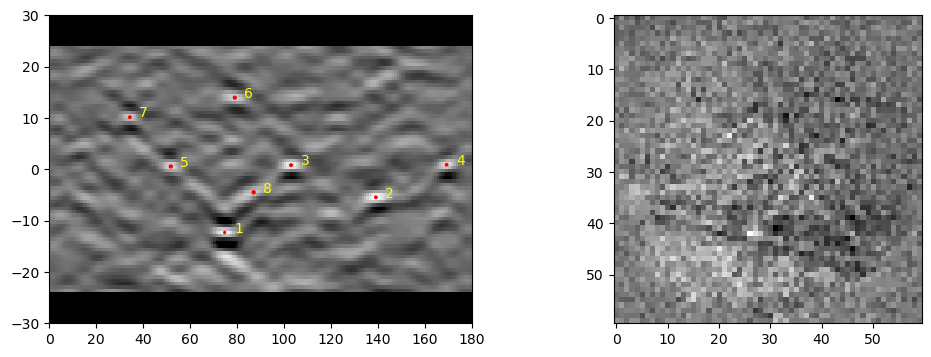

In [13]:
dat1,bnd1, indxer=ebsd_index.index_pats(filename = file,
                                     patstart = 0, npats = 1000,return_indexer_obj = True,
                                     backgroundSub = backgroundsub,
                                     nTheta = nT, nRho=nR,
                                     tSigma = tSig, rSigma = rSig,rhoMaskFrac=rhomask,nBands=nbands, \
                                     phaselist = phaselist, 
                                     PC = PC, camElev=cam_elev, sampleTilt=sampleTilt, 
                                     vendor = vendor, 
                                     verbose = 2)
imshape = (indxer.fID.nRows, indxer.fID.nCols)


In [14]:
dat1

array([[([ 0.49142055, -0.44366331,  0.24821553,  0.70714762], 1.9431697, 19667.203, 0.80592537, 0, 0.34399393, 7, [0, 5, 2, 6], 7),
        ([ 0.45595376,  0.23614562, -0.50143118, -0.69635349], 1.772232 , 21392.125, 0.65944093, 0, 0.5743445 , 7, [1, 3, 2, 3], 7),
        ([ 0.8486765 , -0.13501905,  0.48704409,  0.15590418], 1.8425394, 14528.998, 0.5519603 , 0, 0.78473234, 5, [0, 4, 0, 1], 5),
        ...,
        ([ 0.35762342, -0.06459313,  0.6572944 ,  0.66022518], 1.7647524, 17856.498, 0.6246479 , 0, 0.80595905, 6, [1, 3, 2, 3], 6),
        ([ 0.35975858, -0.06718087,  0.65443424,  0.66164668], 1.6936564, 19693.129, 0.60339695, 0, 0.45867494, 5, [1, 2, 4, 1], 5),
        ([ 0.80377861, -0.21735708,  0.51182564, -0.21149553], 1.6419532, 21506.043, 0.72748715, 0, 0.37678483, 7, [1, 5, 0, 5], 7)],
       [([ 0.75526712,  0.37716653,  0.5350953 ,  0.03146432], 1.9431697, 19667.203, 0.25688434, 1, 0.91838366, 5, [0, 6, 4, 2], 3),
        ([ 0.80122287, -0.26566355,  0.4003987 , -0.356

### Indexed ebsd data
The data output `dat1` here, is a compound numpy array (or array of structured data), that is `[nphases+1, npoints]`.  The data is stored for each phase used in indexing and the dat1\[-1\] layer uses the best guess on which is the most likely phase, based on the fit, and number of bands matched for each phase.  Each data entry contains:


`'quat'`: the orientation expressed as a quaternion with [q0, q1\*i, q2\*j, q3\*k ] using EDAX rotation/reference frame convention by default.

`'iq;`: pattern Image Quality, here expressed as the mean normalized peak intensity (e.g. peak intensity relative to average convolved radon intensity.)
Tends to be a consistent value from scan-to-scan between 1.5 - 2.0.  Values near 1.0 indicate very little contrast between the peaks and the background, and are an indicator that the pattern is not very informative.  

`'pq'`: Pattern Quality, here defined as the mean peak intensity of the detected bands as measured on the convolved radon.

`'cm'`: Confidence Metric, a measure between `[0,1.0]` of the confidence of the index solution.  

`'phase'`: Phase ID index indicating the phase (as it appears in the phase list), with -1 reserved for unindexed patterns assigned to no phase. 

`'fit'`: The Fit, or MAD, with units of degrees. 

`'nmatch'`: Number of bands matched.  



### Band data 
The second output, `bnd1` is also a compound numpy array, with dimensions `[npoints, nbands]`.  Each entry these values for each band:

`'max'`:  convolved radon peak maximum value. 

`'normmax'`: convolved radon normalized (by average convolved radon intensity) peak hights.  Better for making IPF images.  Normally between values 1.0-2.0

`'maxloc'`: the integer location of that max in the randon space as `(int)[rho_indx, theta_index]`.

`'avemax'`: the nearest neighbor average max for the peak.  This is what is later used to calculate the pattern quality. 

`'aveloc'`: the sub-pixel location of the max `(float)[rho_indx, theta_index]`.

`'theta'`and`'rho'`: the equivalent Radon values for theta and rho for the sub-pixel max.

`'valid'`: a 0,1 which indicates if the band is valid or not.  

There are some other metrics reported, but these are mostly for debugging purposes.  Also - these fields may be added onto in the future, but those listed here are expected to be stable.   

## Refine the PC guess
Here we read a set of 5x5 patterns from the center of the scan to make an optimized estimate of the pattern center.  The patterns are read into a numpy array.  Currently, only a single PC is used for each scan, but improvements for this should be coming soon.  With the default optimization method, the initial guess should be close; within ±0.1 -- 0.05, and closer is better.  

In [17]:
startcolrow = [int(imshape[1]//2)-2, int(imshape[0]//2)-2]
fID = ebsd_pattern.get_pattern_file_obj(file)
# returns patterns in an array, and the location in microns of the patterns witin the scan relative to the center of the scan
pats, xyloc = fID.read_data(returnArrayOnly=True, convertToFloat=True, patStartCount=[startcolrow, [5,5]]) 
newPC = pcopt.optimize(pats, indxer, PC0 = PC)
# actually save the PC into the indxer object.  
indxer.PC = newPC
print(newPC)

[0.46200124 0.69670694 0.64542066]


Now use that indexer object to index the whole file.  Setting `npats = -1` will index to the end of the file/array (latter on will be an example of using an array as input).  

The defaults will be to detect all the GPUs on your machine, and use them.  Scheduling is dynamic, so it does not matter if the GPUs are matched. After radon processing/peak finding, the cpus take over for performing the index voting -- thus the number of CPUs needed will depend highly on the number of phases that need to be indexed.  Using the default with `ncpu = -1` will automatically allocate min(10 cpu processes/phase, number of cpu cores on machine).  

The first time this executes, it will take longer as the JIT compilers need to do the initial compile. Currently, the program cache is set to the system `/tmp` directory, so after reboots, many of the programs will need to be recompiled (which happens automatically with the first run)

In [18]:

data, bnddata = ebsd_index.index_pats_distributed(filename = file,patstart = 0, npats = -1,ebsd_indexer_obj = indxer,  ncpu = -1 , verbose =2) 

num cpu/gpu, and number of patterns per iteration: 6 1 1664 12 6
Completed:  256256  --  257920   PPS: 3604    30% 72;166 running;remaining(s)
GPU Done
Completed:  850304  --  851968   PPS: 7846    100% 109;0 running;remaining(s)
...


Display the results as an IPF map.  So far the only implementation is for cubic and hex IPFs - further, more flexible representations are needed here, but are likely going to be best handled by orix or others.  

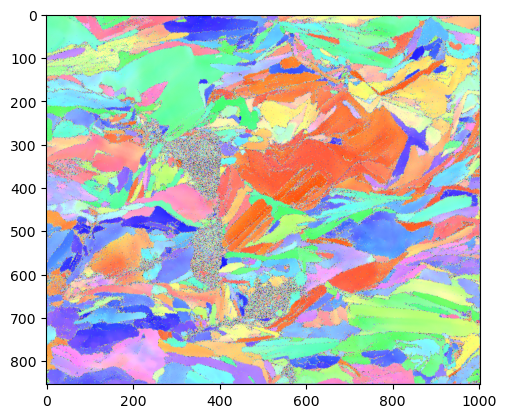

In [19]:
ipfim = IPFcolor.makeipf(data, indxer); plt.imshow(ipfim)

There are some options for using other data metrics for decorating the IPF maps: 

(np.float64(-0.5), np.float64(1000.5), np.float64(893.5), np.float64(-0.5))

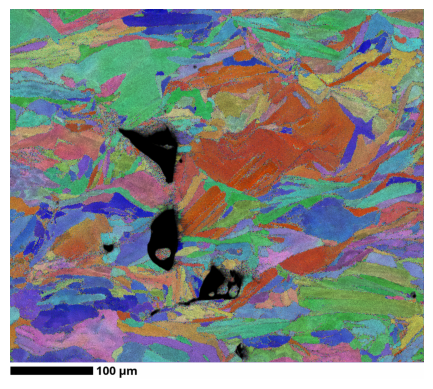

In [20]:
ipfim = IPFcolor.makeipf(data, indxer, graychannel='iq', addmicronbar=True, gamma=0.75); plt.imshow(ipfim); plt.axis('off')

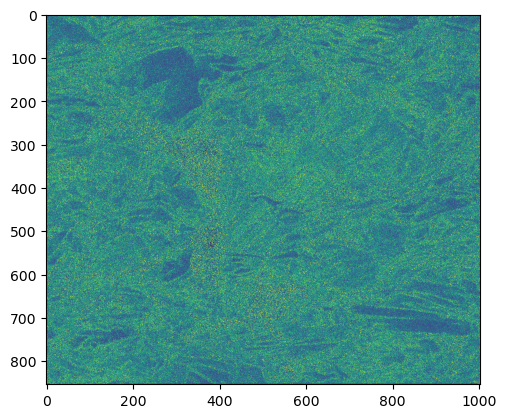

In [21]:
fit = scalarimage.scalarimage(data, indxer, datafield='fit'); plt.imshow(fit);

Or if you would rather do it yourself, something like this would work:

7916.796 50798.13


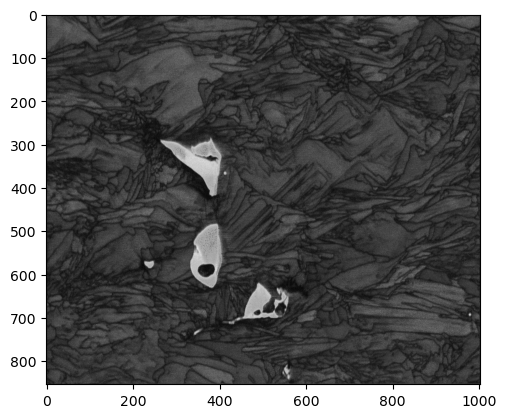

In [22]:
pq = (data[-1]['pq']).reshape(imshape[0],imshape[1]); plt.imshow(pq, cmap='gray')
print(pq.min(), pq.max())

## Writing data out
Still working on this, but there are two output formats for the data arrays from PyEBSDIndex, .ang files, and .oh5 (EDAX's version of the H5EBSD data spec). 

In [ ]:
ebsdfile.writeoh5(filename='MyScanData.oh5', indexer=indxer, data=data)

In [ ]:
ebsdfile.writeang(filename='MyScanData.ang', indexer=indxer, data=data)

### An example of indexing an array of patterns.

It is also possible to index a numpy array of patterns.  
Here we will read part of the UP file above into an array -- note that patterns can take up a lot of RAM.  It is not normally advisable to read in an entire file of patterns if the file size is > 2GB.  

Here we read in 200cols x 300 rows = 60000 patterns starting at column 10, row 5 (0-index based) of the EBSD scan data.  What is important here is that the patterns are returned as a `(N, pH, pW)` numpy float32 array where *N* is the number of patterns, `pH` is the pattern height, and `pW` is the pattern width.  

It should be noted that patterns are expected to be arranged so that `pats[0,0,0]` corresponds to the top-left pixel as one looks at the detector towards the sample (same as the EBSD vendor standards and EMSoft version >=5.0). 

(60000, 60, 60)
float32


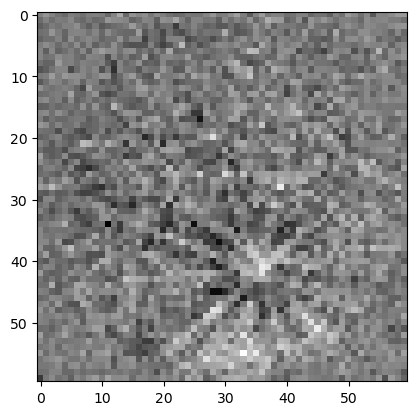

In [23]:
startcolrow = [10,5]
ncol = 200
nrow = 300

f = ebsd_pattern.get_pattern_file_obj(file)
pats, xyloc = f.read_data(returnArrayOnly=True, convertToFloat=True, patStartCount=[startcolrow, [ncol,nrow]])
# read data and return the patterns as an ndarray[npats, npatrows, npatcols], and the x,y locations within the scan (in microns), ndarray[2,npats]
print(pats.shape)
print(pats.dtype)
plt.imshow(pats[0, :, :], cmap='gray')

If the array holds a small number of patterns that can all fit on the GPU at one time, one can avoid the distributed indexing method.  It should be noted that there is built in data chunking (set to fairly conservative limits) to the GPU when using *index_pats*, but no multi-processing of the band voting, so it may take a long while. This small set takes about one minute on a 2019 Mac Pro. Here, we are going to use the same indexer object as above.  

Radon Time: 0.5023874205071479
Convolution Time: 4.2476018741726875
Peak ID Time: 1.176631631096825
Band Label Time: 1.7350942937191576
Total Band Find Time: 7.944864416960627
Band Vote Time:  3.974799749907106


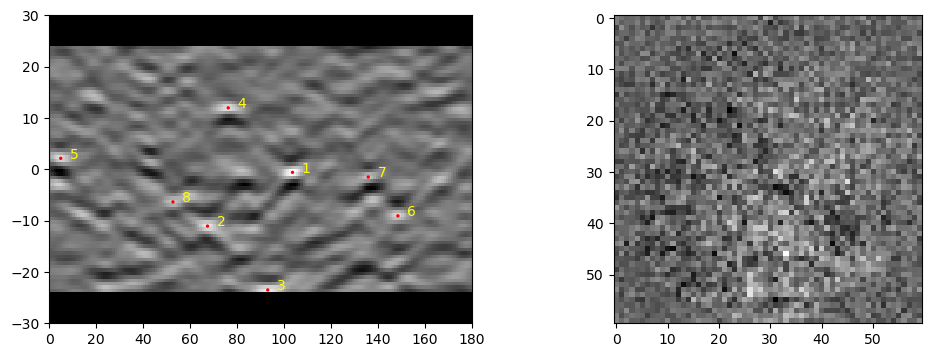

In [24]:
datasm, bnddatsm=ebsd_index.index_pats(patsin = pats, ebsd_indexer_obj = indxer, verbose = 2)

If the array is large, then the distributed indexing works on large input arrays as well.  Here a smaller number of CPU processes are used to minimize overhead of spinning up a new process.  

In [ ]:
datasm, bnddatsm = ebsd_index.index_pats_distributed(patsin = pats, ebsd_indexer_obj = indxer)

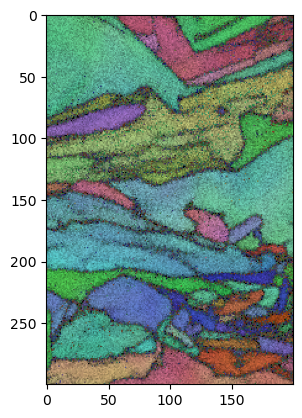

In [26]:
ipfim = IPFcolor.makeipf(datasm, indxer, ncols = 200, graychannel='nmatch'); plt.imshow(ipfim) # nCols needs to be defined for array inputs. 

And of course, one can index a single pattern as well.  In this case, *pat* can be a 2D array `(pH, pW)`:

(60, 60)


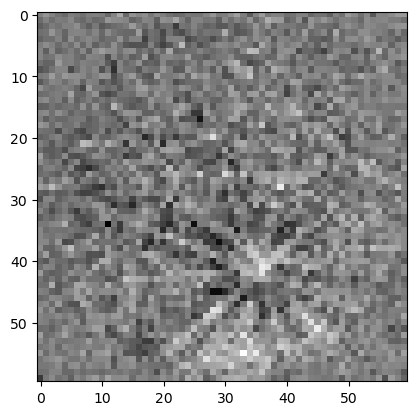

In [27]:
pat1 = pats[0,:, :]
print(pat1.shape)
plt.imshow(pat1, cmap='gray')

Radon Time: 0.007874124916270375
Convolution Time: 0.027734542032703757
Peak ID Time: 0.008475000038743019
Band Label Time: 0.015364582883194089
Total Band Find Time: 0.05955320899374783
Band Vote Time:  0.0017500410322099924
('quat', 'iq', 'pq', 'cm', 'phase', 'fit', 'nmatch', 'matchattempts', 'totvotes')
[([ 0.27121148, -0.37868821,  0.18609422, -0.86510607], 1.7882881, 1.3826607e+09, 0.701611, 0, 0.5727154, 7, [0, 1, 0, 1], 7)]


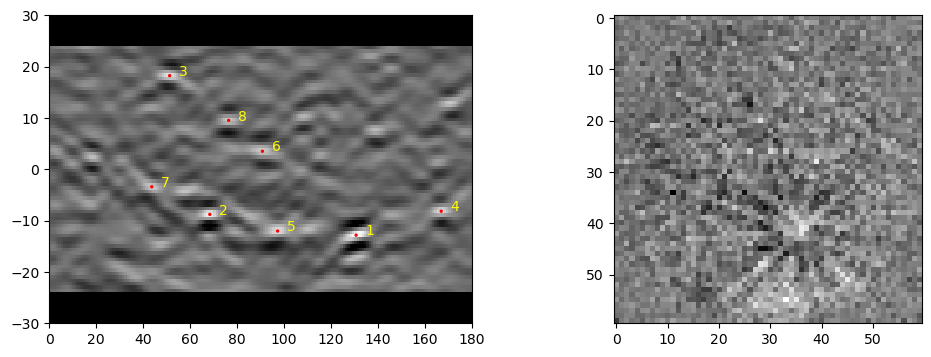

In [28]:
dat1, bnddat1 = ebsd_index.index_pats(patsin = pat1, ebsd_indexer_obj = indxer, verbose=2)
dat1 = dat1[-1]
print(dat1.dtype.names)
print(dat1)





It should be noted that this is a pretty slow indexing of one point. It may be prefered to run this all on the CPU instead:

Radon Time: 0.008000832982361317
Convolution Time: 0.03154970798641443
Peak ID Time: 0.008697875076904893
Band Label Time: 0.015277625061571598
Total Band Find Time: 0.06363083282485604
Band Vote Time:  0.001741624902933836


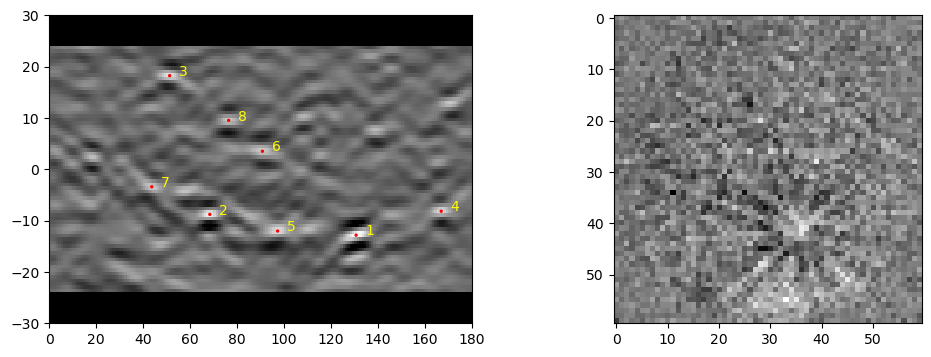

In [29]:
indxerCPU = copy.deepcopy(indxer)
indxerCPU.bandDetectPlan.useCPU = False
dat1, bnddat1 = ebsd_index.index_pats(patsin = pat1, ebsd_indexer_obj = indxerCPU, verbose=2)
dat1 = dat1 = dat1[-1]

### Loading data from an HDF5 File
There is some limited support for specific types of HDF5 files using the _"filename"_ keyword to `index_pats` or `index_pats_distributed`.  However, probably the easiest method is to just point a h5py Dataset at the `patsin` keyword (This makes the important assumption that the patterns are stored in `[npatterns, nrows, ncols]` and the first point stored is the upper left corner of the detector).  See below: 

In [ ]:

h5file = '/Path/to/hdf5/file.h5'
f = h5py.File(h5file, 'r') # this is an HDF5 file type used by EDAX.  
h5pats = f['/Scan 1/EBSD/Data/Pattern'] # location of the pattern array within the HDF5 file.  

# index the first 1000
h5data, h5bnddata, indxer=ebsd_index.index_pats(patsin = h5pats[0:1000,:,:],
                                     patstart = 0, npats = 1000,return_indexer_obj = True,
                                     backgroundSub = backgroundsub,
                                     nTheta = nT, nRho=nR,
                                     tSigma = tSig, rSigma = rSig,rhoMaskFrac=rhomask,nBands=nbands, \
                                     phaselist = phaselist, 
                                     PC = PC, camElev=cam_elev, sampleTilt=sampleTilt, 
                                     vendor = vendor, 
                                     verbose = 0)
#now index them all
h5data, h5banddata = ebsd_index.index_pats_distributed(patsin = h5pats, ebsd_indexer_obj = indxer, ncpu = -1, verbose=2)